In [1]:
# Import all the necessary libraries.
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

In [2]:
# Reset pseudo random generator to a known value so that results are reproducible.
seed = 1
np.random.seed(seed)

In [3]:
# Function used to generate both the training and validation datasets.
def generateDataSet(N):
    # Create training dataset.
    x = np.sort(6*np.random.rand(N,1) - 3)
    # True model.
    y = 0.5*x**2 + x + 2
    # Noise.
    w = np.random.randn(N, 1)
    # Noisy version of the true model.
    y_noisy = y + w
    # Should we include the bias term?
    include_bias = True
    return x, y, y_noisy, include_bias

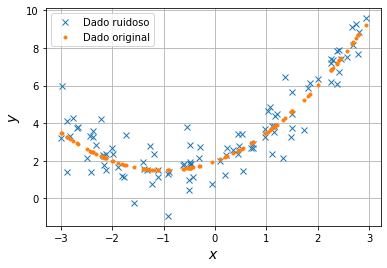

In [4]:
# Dataset size.
N = 100

# Generate the datasets.
x, y, y_noisy, include_bias = generateDataSet(N)

# Plot original data versus noisy version.
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x, y, '.', label='Dado original')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
# Save figure.
#plt.savefig("function.png", dpi=600)
# Show the plot.
plt.show()

# Holdout cross-validation (70/30%)

In [5]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Split the whole dataset into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.3, random_state=seed)

# Print size of the datasets.
print('Tamanho do conjunto de treinamento:', len(y_train))
print('Tamanho do conjunto de validação:', len(y_val))

mse_train_vec = []
mse_val_vec = []
# Iterate over the specified degrees.
poly_orders = range(1, 31)
for d in poly_orders:
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Train the model.
    poly_reg.fit(x_train, y_train)
    
    # Predict with the training dataset.
    y_train_predict = poly_reg.predict(x_train)
    
    # Predict with the validation dataset.
    y_val_predict = poly_reg.predict(x_val)
    
    # Calculate and store the MSE for the validation dataset into an array.
    mse_val_vec.append(mean_squared_error(y_val, y_val_predict))
    
    # Calculate and store the MSE for the training dataset into an array.
    mse_train_vec.append(mean_squared_error(y_train, y_train_predict))

holdout_time = timeit.default_timer() - starttime
print("Tempo de execução do holdout: %1.4f [s]" % (holdout_time))

Tamanho do conjunto de treinamento: 70
Tamanho do conjunto de validação: 30
Tempo de execução do holdout: 0.2727 [s]


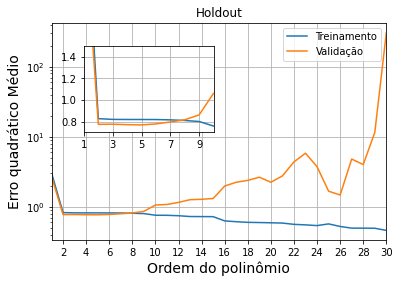

In [6]:
# Plot results.
fig = plt.figure()
plt.plot(poly_orders, mse_train_vec,  label='Treinamento')
plt.plot(poly_orders, mse_val_vec,  label='Validação')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.yscale('log')
plt.title('Holdout')
plt.legend()
plt.grid()

left, bottom, width, height = [0.2, 0.5, 0.3, 0.3]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, mse_train_vec,  label='Treinamento')
ax1.plot(poly_orders, mse_val_vec,  label='Validação')
ax1.set_xlim(1, 10)
ax1.set_ylim(0.7, 1.5)
ax1.set_xticks(range(1,11,2))
ax1.grid()

# Save figure.
#plt.savefig("holdout.png", dpi=600)
#Show the plot.
plt.show()

# k-fold cross-validation (k=10)

In [7]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the k-Fold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

kfold_mean_vec = []
kfold_std_vec = []
# Iterate over the specified degrees.
poly_orders = range(1, 31)
for d in poly_orders:
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Calculate the cross-validation score with kfold object.
    # OBS.: All scorer objects follow the convention that higher return values are better than lower return values. 
    #       Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, 
    #       are available as neg_mean_squared_error which return the negated value of the metric.
    lin_scores = cross_val_score(poly_reg, x, y_noisy, scoring='neg_mean_squared_error', cv=kfold)
    
    # Convert back to MSE by multiplying it by minus one.
    scores = -lin_scores
    # Mean of the MSE values, i.e., calculate ter MSE for each one of the folds.
    kfold_mean_vec.append(scores.mean())
    # Standard deviation of the MSE values.
    kfold_std_vec.append(scores.std())

kfold_time = timeit.default_timer() - starttime
print("Tempo de execução do k-Fold: %1.4f [s]" % (kfold_time))

Tempo de execução do k-Fold: 2.4283 [s]


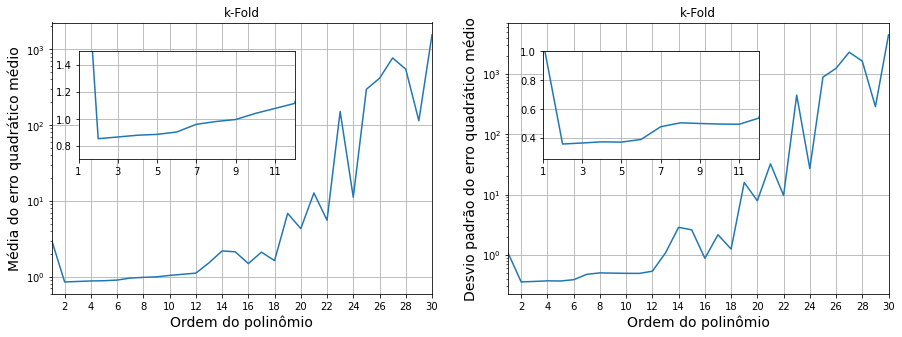

In [8]:
# Plot results.
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(poly_orders, kfold_mean_vec, label='Erro quadrático médio')
plt.yscale('log')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático médio', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()
plt.title('k-Fold')

left, bottom, width, height = [0.15, 0.5, 0.2, 0.3]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, kfold_mean_vec)
ax1.set_xlim(1, 12)
ax1.set_ylim(0.7, 1.5)
ax1.set_xticks(range(1,13,2))
ax1.grid()

ax = plt.subplot(1, 2, 2)
plt.title('k-Fold')
plt.plot(poly_orders, kfold_std_vec, label='Desvio padrão do erro')
plt.yscale('log')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão do erro quadrático médio', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()

left, bottom, width, height = [0.58, 0.5, 0.2, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(poly_orders, kfold_std_vec)
ax2.set_xlim(1, 12)
ax2.set_ylim(0.25, 1.0)
ax2.set_xticks(range(1,13,2))
ax2.grid()

# Save figure
#plt.savefig("kfold.png", dpi=600)
#Show the plot.
plt.show()

## Leave-p-out cross-validation (p=2)

In [9]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LPOCV object.
# With p = 2 with have 4950 pairs of training and validation datasets. 
# That is, we have 4950 training/validation processes, where the validation
# set has 2 samples each.
lpocv = LeavePOut(p=2)

lpo_mean_vec = []
lpo_std_vec = []
# Iterate over the specified degrees.
poly_orders = range(1, 31)
for d in poly_orders:
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Calculate the cross-validation score with LPO object.
    # OBS.: All scorer objects follow the convention that higher return values are better than lower return values. 
    #       Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, 
    #       are available as neg_mean_squared_error which return the negated value of the metric.
    lin_scores = cross_val_score(poly_reg, x, y_noisy, scoring='neg_mean_squared_error', cv=lpocv)
        
    scores = -lin_scores
    # Mean of the MSE values, i.e., calculate ter MSE for each one of the test sets.
    lpo_mean_vec.append(scores.mean())
    # Standard deviation of the MSE values.    
    lpo_std_vec.append(scores.std())
    
lpo_time = timeit.default_timer() - starttime
print("Tempo de execução do leave-p-out: %1.4f [s]" % (lpo_time))

Tempo de execução do leave-p-out: 851.3668 [s]


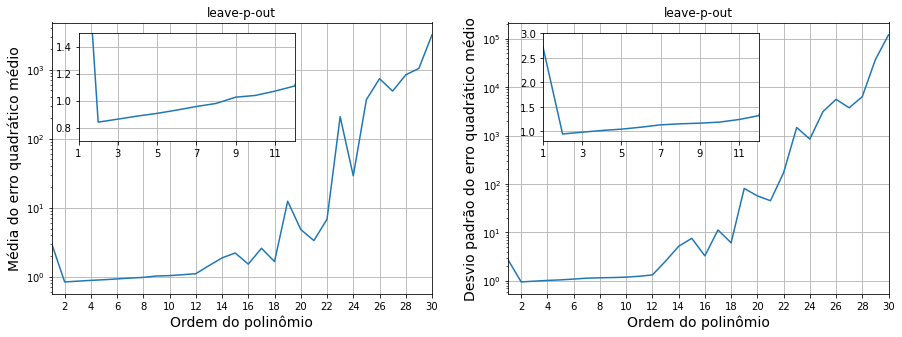

In [10]:
# Plot results.
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(poly_orders, lpo_mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático médio', fontsize=14)
plt.yscale('log')
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()
plt.title('leave-p-out')

left, bottom, width, height = [0.15, 0.55, 0.2, 0.3]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, lpo_mean_vec)
ax1.set_xlim(1, 12)
ax1.set_ylim(0.7, 1.5)
ax1.set_xticks(range(1,13,2))
ax1.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(poly_orders, lpo_std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão do erro quadrático médio', fontsize=14)
plt.yscale('log')
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()
plt.title('leave-p-out')

left, bottom, width, height = [0.58, 0.55, 0.2, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(poly_orders, lpo_std_vec)
ax2.set_xlim(1, 12)
ax2.set_ylim(0.8, 3)
ax2.set_xticks(range(1,13,2))
ax2.grid()

# Save figure
#plt.savefig("leave_p_out.png", dpi=600)
#Show the plot.
plt.show()

# Comparing results

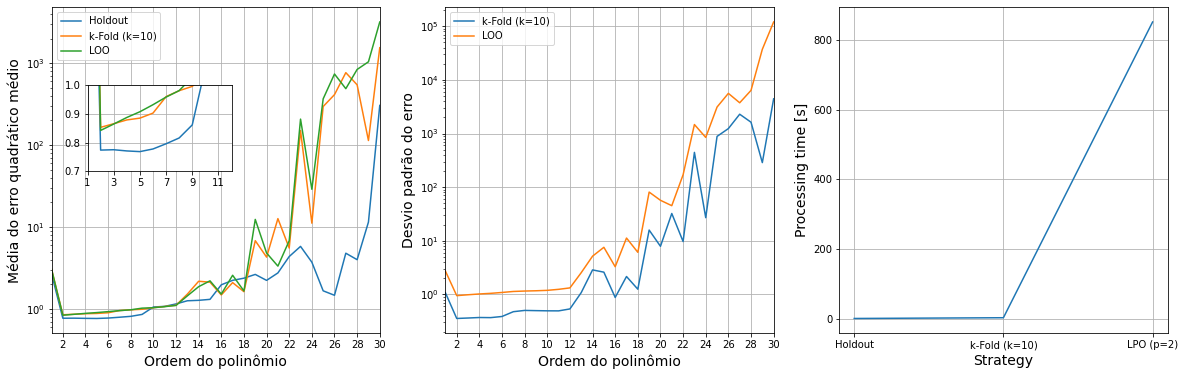

In [12]:
# Plot results.
fig = plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(poly_orders, mse_val_vec, label='Holdout')
plt.plot(poly_orders, kfold_mean_vec, label='k-Fold (k=10)')
plt.plot(poly_orders, lpo_mean_vec, label='LOO')
plt.yscale('log')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático médio', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.legend()
plt.grid()

left, bottom, width, height = [0.15, 0.5, 0.1, 0.2]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, mse_val_vec, label='Holdout')
ax1.plot(poly_orders, kfold_mean_vec, label='k-Fold (k=10)')
ax1.plot(poly_orders, lpo_mean_vec, label='LOO')
ax1.set_xlim(1, 12)
ax1.set_ylim(0.7, 1)
ax1.set_xticks(range(1,13,2))
ax1.grid()

ax = plt.subplot(1, 3, 2)
plt.plot(poly_orders, kfold_std_vec, label='k-Fold (k=10)')
plt.plot(poly_orders, lpo_std_vec, label='LOO')
plt.yscale('log')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão do erro', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 3)
times = [holdout_time, kfold_time, lpo_time]
strategies = ['Holdout','k-Fold (k=10)','LPO (p=2)']
plt.plot(strategies, times)
plt.xlabel('Strategy', fontsize=14)
plt.ylabel('Processing time [s]', fontsize=14)
plt.grid()

#Show the plot.
plt.show()

## Plot comparison of  the true model against noisy and predicted versions.

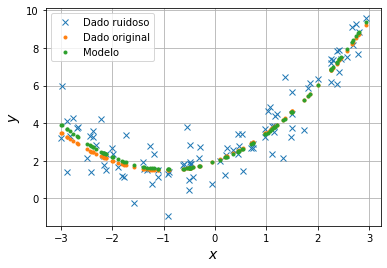

In [13]:
# Instantiate a polynomial.
poly = PolynomialFeatures(degree=2, include_bias=include_bias)
# Instantiate a scaler.
scaler = StandardScaler()
# Instantiate a linear regressor.
reg = LinearRegression()

# Create a pipeline of actions.
poly_reg = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Train the model with the ideal order.
poly_reg.fit(x, y_noisy)

# Predict using the trained model.
y_pred = poly_reg.predict(x)

# Plot original data versus noisy version and predicted version.
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x, y, '.', label='Dado original')
plt.plot(x, y_pred, '.', label='Modelo')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
# Show the plot.
plt.show()